# DBSCAN Clustering — Theory, Implementation, and Visualization

This notebook is a complete, self-contained guide to **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**.  
It covers the **intuition**, the **math**, **parameter selection**, an **educational from-scratch implementation**, the **scikit-learn** implementation, and **visualizations** on synthetic datasets.


## 1) Intuition

DBSCAN groups points that form **dense regions** and marks points in low-density areas as **noise**. Unlike `$k$`-means, you do **not** specify the number of clusters beforehand and DBSCAN can discover **arbitrarily shaped** clusters (e.g., two moons), and it is **robust to outliers**.

## 2) Math & Definitions

Let a dataset be $X = \{\mathbf{x}_1,\ldots,\mathbf{x}_n\} \subset \mathbb{R}^d$, a distance metric $d(\cdot,\cdot)$, a radius parameter $\varepsilon > 0$, and a minimum neighborhood size $min\_samples \in \mathbb{N}$.

- **$\varepsilon$-neighborhood** of a point $\mathbf{x}$:
$$
\mathcal{N}_\varepsilon(\mathbf{x}) = \{\mathbf{y}\in X \;|\; d(\mathbf{x}, \mathbf{y}) \le \varepsilon\}.
$$

- **Core point**: $\mathbf{x}$ is a core point if
$$
|\mathcal{N}_\varepsilon(\mathbf{x})| \;\ge\; min\_samples.
$$

- **Directly density-reachable**: $\mathbf{y}$ is directly density-reachable from $\mathbf{x}$ if $\mathbf{x}$ is a **core** point and $\mathbf{y} \in \mathcal{N}_\varepsilon(\mathbf{x})$.

- **Density-reachable**: $\mathbf{y}$ is density-reachable from $\mathbf{x}$ if there exists a chain of points
$$
\mathbf{x} = \mathbf{x}_0, \mathbf{x}_1, \ldots, \mathbf{x}_k = \mathbf{y}
$$
such that each $\mathbf{x}_{i+1}$ is directly density-reachable from $\mathbf{x}_i$.

- **Density-connected**: $\mathbf{x}$ and $\mathbf{y}$ are density-connected if there exists a point $\mathbf{z}$ such that both $\mathbf{x}$ and $\mathbf{y}$ are density-reachable from $\mathbf{z}$.

- **Border point**: not a core point, but density-reachable from at least one core point.

- **Noise / Outlier**: neither a core nor a border point (i.e., not density-reachable from any core point).

**DBSCAN cluster**: a **maximal** set of density-connected points.

### Algorithm (high level)
1. For each unvisited point $\mathbf{x}$, compute $\mathcal{N}_\varepsilon(\mathbf{x})$.
2. If $|\mathcal{N}_\varepsilon(\mathbf{x})| \ge min\_samples$, start a new cluster and **expand** it by iteratively adding all points that are density-reachable from any core point in the cluster.
3. Otherwise, mark $\mathbf{x}$ as noise (it may later become a border point if reached from a core point).

### Complexity (informal)
Using an efficient spatial index (KD-tree / Ball-tree), neighbor queries can be close to $O(\log n)$ on average; with $n$ queries the complexity is about $O(n \log n)$. A naive implementation with pairwise distances is $O(n^2)$.

## 3) Choosing Parameters: $\varepsilon$ and $min\_samples$

- `$min\_samples$`: a common heuristic is `$min\_samples = d+1$` (dimension + 1) or between `4` and `10` for many 2D demos. Larger values demand denser clusters (fewer clusters, more noise).
- `$\varepsilon$`: use a **$k$-distance plot**. Let $k = min\_samples - 1$. For each point, compute the distance to its $k$-th nearest neighbor, then sort these distances. Look for an **elbow**; that value is a good $\varepsilon$ candidate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

def k_distance_plot(X, k, title="k-distance plot"):
    nbrs = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(X)
    distances, _ = nbrs.kneighbors(X)
    kth = np.sort(distances[:, -1])
    plt.figure()
    plt.plot(kth)
    plt.xlabel("Points (sorted)")
    plt.ylabel(f"Distance to {k}-th neighbor")
    plt.title(title)
    plt.show()

def safe_silhouette(X, labels):
    mask = labels != -1
    if mask.sum() <= 2:
        return None
    unique = np.unique(labels[mask])
    if unique.size < 2:
        return None
    try:
        return float(silhouette_score(X[mask], labels[mask]))
    except Exception:
        return None


## 4) Educational "From-Scratch" DBSCAN (Naïve, $O(n^2)$)

This implementation is **for learning**. It computes pairwise distances with NumPy (quadratic time), which is fine for small datasets. For larger data, use spatial indexes (KD/ball trees) or `sklearn`'s optimized version.

In [2]:
import numpy as np

def dbscan_naive_clean(X, eps=0.3, min_samples=5):
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    labels = -np.ones(n, dtype=int)
    diffs = X[:, None, :] - X[None, :, :]
    dist2 = np.sum(diffs * diffs, axis=2)
    eps2 = eps * eps
    neighbors = [np.where(dist2[i] <= eps2)[0] for i in range(n)]
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0

    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        Ni = neighbors[i]
        if Ni.size < min_samples:
            labels[i] = -1
            continue
        # start new cluster
        labels[i] = cluster_id
        seeds = list(Ni.tolist())
        k = 0
        while k < len(seeds):
            p = seeds[k]
            if not visited[p]:
                visited[p] = True
                Np = neighbors[p]
                if Np.size >= min_samples:
                    for q in Np:
                        if q not in seeds:
                            seeds.append(int(q))
            if labels[p] < 0:
                labels[p] = cluster_id
            k += 1
        cluster_id += 1
    return labels


### Demo (From-Scratch) on a Tiny Dataset

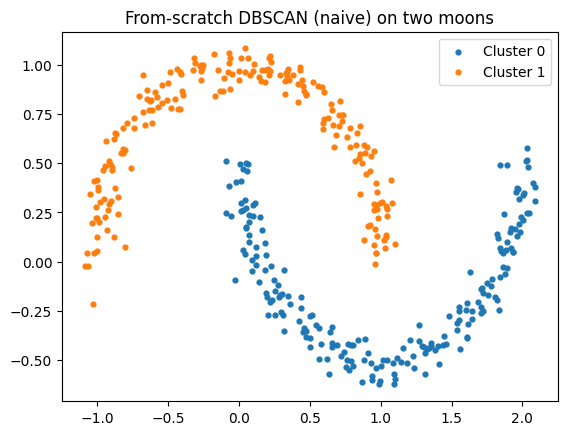

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X_small, _ = make_moons(n_samples=400, noise=0.06, random_state=42)
labels_small = dbscan_naive_clean(X_small, eps=0.25, min_samples=5)

plt.figure()
for lab in sorted(set(labels_small)):
    mask = labels_small == lab
    plt.scatter(X_small[mask, 0], X_small[mask, 1], s=12, label=f"Cluster {lab}")
plt.title("From-scratch DBSCAN (naive) on two moons")
plt.legend()
plt.show()


## 5) Scikit-Learn DBSCAN and Visualizations
We now use the optimized implementation from `sklearn.cluster import DBSCAN` with different synthetic datasets.

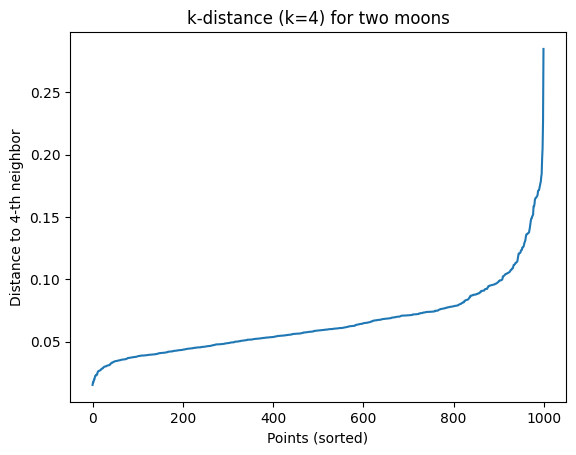

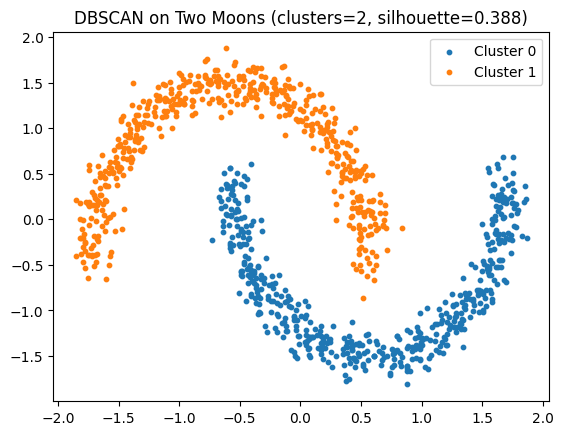

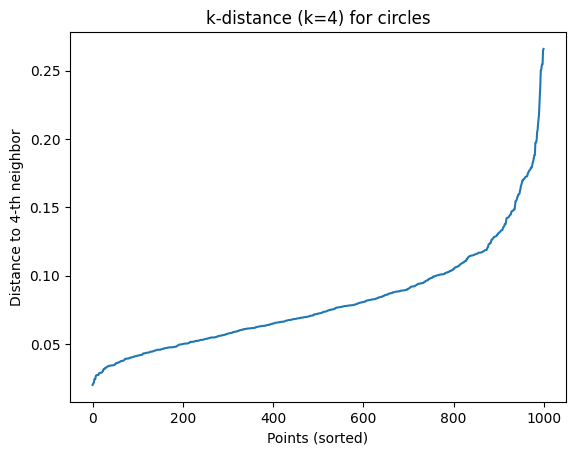

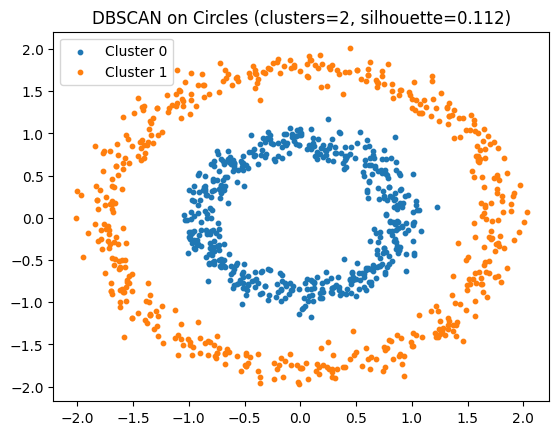

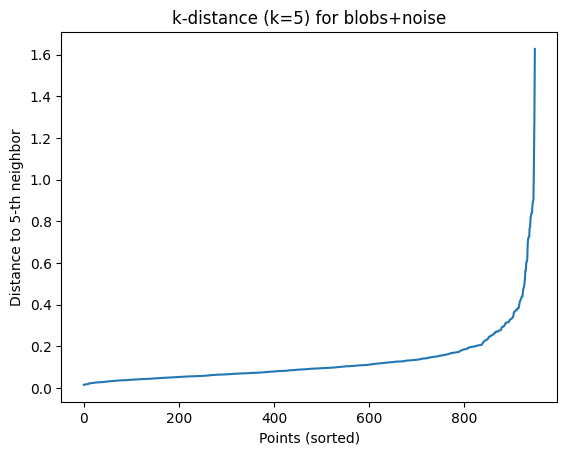

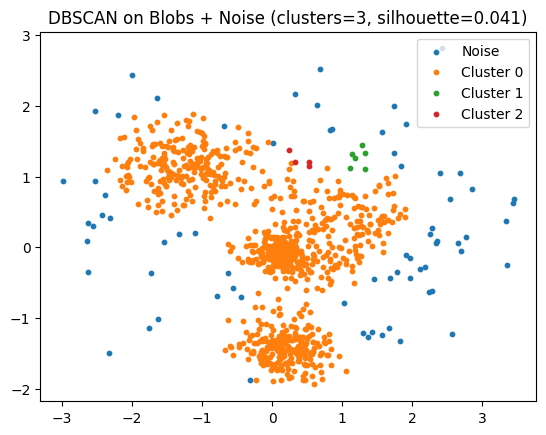

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler

def run_and_plot_dbscan(X, eps=0.3, min_samples=5, title="DBSCAN result"):
    Xs = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(Xs)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    sil = safe_silhouette(Xs, labels)

    plt.figure()
    for lab in sorted(set(labels)):
        mask = labels == lab
        plt.scatter(Xs[mask, 0], Xs[mask, 1], s=10, label=("Noise" if lab == -1 else f"Cluster {lab}"))
    subtitle = f"clusters={n_clusters}"
    if sil is not None:
        subtitle += f", silhouette={sil:.3f}"
    plt.title(f"{title} ({subtitle})")
    plt.legend()
    plt.show()
    return labels

# Two moons
X_moons, _ = make_moons(n_samples=1000, noise=0.07, random_state=0)
k_distance_plot(StandardScaler().fit_transform(X_moons), k=4, title="k-distance (k=4) for two moons")
_ = run_and_plot_dbscan(X_moons, eps=0.25, min_samples=5, title="DBSCAN on Two Moons")

# Concentric circles
X_circ, _ = make_circles(n_samples=1000, factor=0.5, noise=0.06, random_state=1)
k_distance_plot(StandardScaler().fit_transform(X_circ), k=4, title="k-distance (k=4) for circles")
_ = run_and_plot_dbscan(X_circ, eps=0.25, min_samples=5, title="DBSCAN on Circles")

# Blobs with noise
X_blobs, _ = make_blobs(n_samples=900, centers=4, cluster_std=[1.0, 2.2, 0.7, 1.5], random_state=2)
X_blobs = np.vstack([X_blobs, np.random.uniform(low=-10, high=10, size=(50, 2))])
k_distance_plot(StandardScaler().fit_transform(X_blobs), k=5, title="k-distance (k=5) for blobs+noise")
_ = run_and_plot_dbscan(X_blobs, eps=0.25, min_samples=6, title="DBSCAN on Blobs + Noise")


## 6) Parameter Sweep (Grid) and Simple Selection

We try multiple `$(\varepsilon, min\_samples)$` pairs and (where valid) report **silhouette** on non-noise points. This is **not** a universal objective for DBSCAN (because of noise and arbitrary shapes), but it helps explore sensitivity.

In [5]:
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

def grid_search_dbscan(X, eps_list, min_samples_list):
    Xs = StandardScaler().fit_transform(X)
    out = []
    for eps, ms in itertools.product(eps_list, min_samples_list):
        db = DBSCAN(eps=eps, min_samples=ms).fit(Xs)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        sil = safe_silhouette(Xs, labels)
        out.append((eps, ms, n_clusters, (sil if sil is not None else float("nan"))))
    return out

X_moons, _ = make_moons(n_samples=1000, noise=0.07, random_state=0)
eps_list = [0.15, 0.2, 0.25, 0.3, 0.35]
min_samples_list = [4, 5, 8, 12]
grid_results = grid_search_dbscan(X_moons, eps_list, min_samples_list)

print("eps\tmin_samples\tclusters\tsilhouette(ignoring noise)")
for eps, ms, nc, sil in grid_results:
    if np.isnan(sil):
        print(f"{eps:.2f}\t{ms:>3}\t\t{nc:>3}\t\tNaN")
    else:
        print(f"{eps:.2f}\t{ms:>3}\t\t{nc:>3}\t\t{sil:.3f}")


eps	min_samples	clusters	silhouette(ignoring noise)
0.15	  4		  2		0.390
0.15	  5		  2		0.390
0.15	  8		  2		0.392
0.15	 12		  4		0.066
0.20	  4		  2		0.389
0.20	  5		  2		0.389
0.20	  8		  2		0.389
0.20	 12		  2		0.389
0.25	  4		  2		0.388
0.25	  5		  2		0.388
0.25	  8		  2		0.388
0.25	 12		  2		0.388
0.30	  4		  1		NaN
0.30	  5		  1		NaN
0.30	  8		  2		0.390
0.30	 12		  2		0.390
0.35	  4		  1		NaN
0.35	  5		  1		NaN
0.35	  8		  2		0.390
0.35	 12		  2		0.390


## 7) Distance Metrics, Feature Scaling, and Practical Tips

- **Metric**: DBSCAN supports different metrics (`'euclidean'`, `'manhattan'`, `'cosine'`, etc.). In high dimensions, cosine or correlation can be more meaningful than Euclidean.
- **Scaling**: Always consider **standardization** (zero mean, unit variance) or domain-informed scaling so that each feature contributes appropriately to distances.
- **min\_samples**: Increasing it requires denser neighborhoods to form clusters, leading to **fewer clusters** and **more noise**.
- **$\varepsilon$**: Use the **$k$-distance** elbow as a starting point; then refine based on domain knowledge.
- **Limitations**: DBSCAN can struggle when clusters have **varying densities** — HDBSCAN can help in that case.

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.datasets import make_blobs

Xv, _ = make_blobs(n_samples=600, centers=3, cluster_std=[1.0, 2.5, 1.4], n_features=5, random_state=7)
Xv_norm = normalize(Xv)
db = DBSCAN(eps=0.1, min_samples=6, metric='cosine').fit(Xv_norm)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Cosine metric example — clusters found:", n_clusters)


Cosine metric example — clusters found: 2


## 8) References & Further Reading

- M. Ester, H.-P. Kriegel, J. Sander, X. Xu (1996). *A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise.* KDD.
- scikit-learn User Guide: Clustering — DBSCAN.
- HDBSCAN: hierarchical density-based clustering for varying densities.
